# Developing scripts to test different connectivity schemes

In [6]:
import jax
import math
import jax.numpy as jnp
import optax
import flax
from flax import nnx
from flax.nnx.nn import initializers
from typing import Callable
import orbax.checkpoint as ocp
import json
import os
import pickle
import numpy as np
from collections import defaultdict

# from PseudoMLP import PseudoMLP
from utils import clipping_ste

import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import get_cmap
import seaborn as sns

In [13]:
# define a function to return a tensor with connectivity constraints
def intercore_connectivity(
    input_cores: int,
    output_cores: int,
    slots_per_core: int,
    avg_slot_connectivity: int,
    key: jax.random.key,
    ):

    """
    Returns a tensor C with shape (input_cores, total_input_slots, output_cores, total_output_slots).
    C[ci, si, co, so] can be [-2, -1, 0, 1, 2].
    1: connection to positive slots
    -1: connection to negative slots
    0: no connection
    -2: rare but repeated connection to negative slot
    2: rare but repeated connection to positive slot
    """

    # define the constants
    total_input_slots = input_cores * slots_per_core
    total_output_slots = output_cores * slots_per_core

    # define the lists of (core, slot) tuples
    Li = [(ci, si) for ci in range(input_cores) for si in range(slots_per_core)]
    Lo = [(co, so) for co in range(output_cores) for so in range(slots_per_core)]
    assert len(Li) == total_input_slots, "Incorrect number of input slots, check input_cores and slots_per_core values"
    assert len(Lo) == total_output_slots, "Incorrect number of output slots, check output_cores and slots_per_core values"
    
    # print(Li)
    # print(Lo)

    # define the positive and negative mapping dicts
    pos_mapping = defaultdict(list)
    neg_mapping = defaultdict(list)

    # construct the positive mapping
    for (co, so) in Lo:
        

        # pick a random number of slots it can receive input from
        key, subkey = jax.random.split(key)
        beta = jax.random.poisson(key=key, lam=avg_slot_connectivity)

        # pick random slots from Li
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key=key, a=len(Li), shape=(beta,), replace=True) # allow for repeated connections
        connections = [Li[i] for i in idx]
        if beta > 0:
            pos_mapping[(co, so)] = connections
        else:
            pos_mapping[(co, so)] = []


    print(f"Positive mapping: {pos_mapping}")

    # construct the negative mapping
    for k, v in pos_mapping.items():
        (co, so) = k
        # check if there are any connections
        if len(v) == 0:
            continue
        else:
            # print(v, len(v))
            for ti in v:
                # print(ti)
                # choose some slots where negative connections can be made
                key, subkey = jax.random.split(key)
                gamma = jax.random.choice(key=key, a=slots_per_core, shape=(1,), replace=True)[0].item()
                neg_mapping[ti].append((co, gamma))

    print(f"Negative mapping: {neg_mapping}")

    # construct the tensor for positive mappings
    C = jnp.zeros((input_cores, slots_per_core, output_cores, slots_per_core))

    for k, v in pos_mapping.items():
        (co, so) = k

        for ti in v:
            (ci, si) = ti
            C = C.at[ci, si, co, so].add(1)

    # construct the tensor for negative mappings
    for k, v in neg_mapping.items():
        (ci, si) = k

        if len(v) == 0:
            print(f"zero -ve mappings from core {k}")
            continue
        else:
            for to in v:
                (co, so) = to
                C = C.at[ci, si, co, so].add(-1)

    return C




Positive mapping: defaultdict(<class 'list'>, {(0, 0): [(2, 2), (3, 3), (0, 2), (0, 2), (2, 2)], (0, 1): [(0, 1), (2, 2), (3, 3), (2, 1), (2, 2)], (0, 2): [(1, 2), (0, 2), (1, 0), (3, 1), (2, 0)], (0, 3): [(2, 0), (2, 3), (3, 2)], (1, 0): [(3, 0), (0, 1), (2, 3)], (1, 1): [(3, 3), (1, 1), (0, 2)], (1, 2): [(0, 3), (2, 3)], (1, 3): [(3, 0), (0, 3), (0, 2), (0, 1)], (2, 0): [(0, 2), (0, 0), (0, 3), (2, 1), (0, 1)], (2, 1): [(0, 1), (2, 0), (2, 0), (0, 3), (1, 1)], (2, 2): [(2, 3), (1, 1), (1, 0), (1, 1)], (2, 3): [(2, 3), (1, 2), (1, 2), (3, 3)], (3, 0): [(1, 2), (3, 3)], (3, 1): [(1, 2), (0, 1), (2, 0), (3, 0), (3, 0), (3, 2)], (3, 2): [(0, 2), (1, 0), (0, 3), (3, 0), (3, 0), (3, 0)], (3, 3): [(1, 2), (0, 3), (2, 0), (0, 1), (3, 3), (2, 0)], (4, 0): [(1, 0), (1, 1), (2, 3), (1, 2), (2, 1)], (4, 1): [(1, 0), (3, 3), (2, 2), (2, 3), (3, 2)], (4, 2): [(2, 1), (3, 2), (2, 1), (2, 3)], (4, 3): [(2, 2), (2, 2), (3, 0), (2, 0)]})
Negative mapping: defaultdict(<class 'list'>, {(2, 2): [(0, 3), 

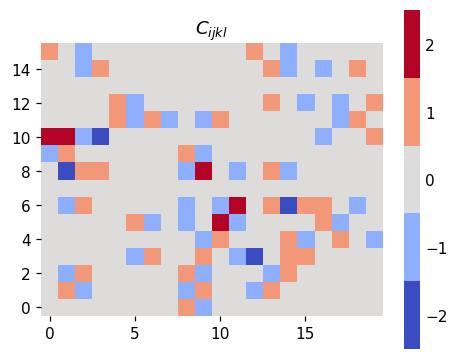

In [39]:
key = jax.random.key(20)
key, subkey = jax.random.split(key)
test_run = intercore_connectivity(input_cores = 4, output_cores = 5, slots_per_core = 4, avg_slot_connectivity=4, key=key)

# plotting
data = test_run.reshape(4*4, 5*4)

# Define the discrete values and boundaries
values = np.array([-2, -1, 0, 1, 2])
bounds = np.array([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])  # Boundaries for the colormap

# Create a colormap with 5 colors from the coolwarm colormap
base_cmap = plt.colormaps['coolwarm']
colors = base_cmap(np.linspace(0, 1, 5))
cmap = ListedColormap(colors)

# Create a norm to map the data values to colormap indices
norm = BoundaryNorm(bounds, cmap.N)

# Create the plot
fig, ax = plt.subplots(figsize=(5, 5), dpi=110)
ax.set_title(r"$C_{ijkl}$")
im = ax.imshow(data, cmap=cmap, norm=norm, interpolation='nearest', origin='lower')

# Add a colorbar
cbar = plt.colorbar(im, ticks=values, shrink=0.8)
# cbar.set_label('Connection Type')
cbar.outline.set_visible(False)
cbar.ax.tick_params(which='both', length=0, width=0, pad=3)
cbar.ax.minorticks_off() 

# Remove the spines from the colorbar

sns.despine(fig, top=True, right=True, left=True, bottom=True)


balanced!


(array([0., 0., 5., 0., 0.]),
 array([-0.5       , -0.30000001, -0.09999999,  0.10000002,  0.30000001,
         0.5       ]),
 <BarContainer object of 5 artists>)

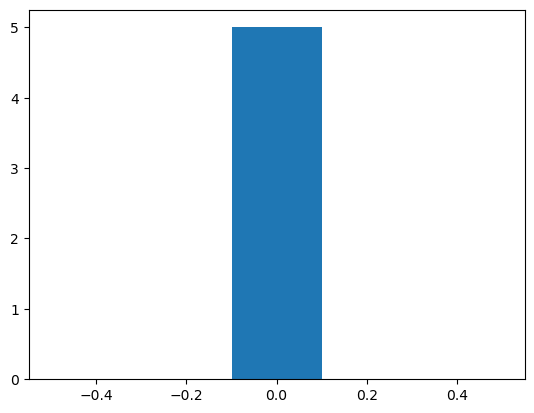

In [ ]:
def verify_connectivity(C):
    """
    Verify if the connectivity matrix makes sense
    - Each core must have equal number of positive and negative connections on an average
    - Returs a distribution of connections per core.
    - Distribution should be a delta zero with ideally no outliers
    """

    assert len(C.shape) == 4, "C must be a 4D tensor"

    balance_list = []

    # check for cores taking inputs
    for co in range(C.shape[2]):
        conn = jnp.sum(C[:, :, co, :])
        balance_list.append(conn)

    perc = jnp.percentile(a=jnp.array(balance_list), q=95)
    if perc == 0:
        print("Balanced!")
    else:
        print("Unbalanced")

    return balance_list


balance_list = verify_connectivity(test_run)
plt.hist(balance_list, bins=5)

# One-to-one connectivity

* Every core in layer $l-1$ connects exactly to one core in layer $l$.
* Cores in layer $l-1$ send their outputs in a chunkwise random manner to the cores in layer $l$
* Let $x_n (s) \in \mathbb{R}^{P}$ be a "chunk" of the output present at a given slot $s$
* Define a tensor $C \in \mathbb{\{-1, 0, +1\}}^{(i, j, s^{l-1}), (k, l, s^{l})}$ which says:
    * If the core in layer $l-1$ at index $(i, j)$ is connected to a core in layer $l$ at index $(k, l)$ and the slot $s^{l-1}$ is connected to slot $s^l$, then
    $$
    C[i,j,k,l,s^{l-1}, s^l] = 
    \begin{cases}
    -1, \quad x_n(s^{l}) \in x^-, \\
    +1, \quad x_n(s^{l}) \in x^+
    \end{cases}
    $$

(2, 4, 16, 16)


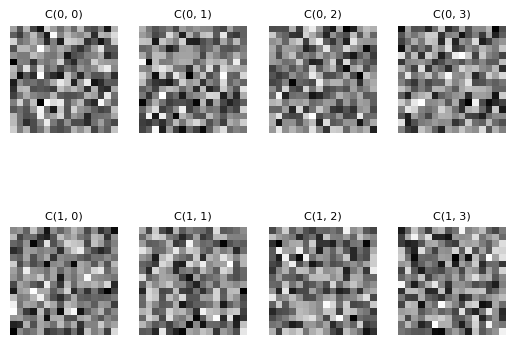

In [4]:
# weights on the cores
core_rows = 16
core_cols = 16
total_cores = 8
num_layers = 2
cores_per_layer = total_cores // num_layers

# initialize weights on all the cores
rngs = nnx.Rngs(params=1, activations=2, masks=3)
initializer = flax.nnx.nn.initializers.glorot_normal()
weights = initializer(rngs.params(), (num_layers, cores_per_layer, core_rows, core_cols))
print(weights.shape)

fig, ax = plt.subplots(weights.shape[0], weights.shape[1])

for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        ax[i, j].imshow(weights[i, j, ...], cmap='gray')
        ax[i, j].set_title(f"C{i, j}", fontsize = 8)
        ax[i, j].axis('off')

In [ ]:
# scrambling but keeping balance condition

class SimpleScramble(nnx.Module):
    def __init__(
        self,
        input_length: int,
        core_length: int,
        slot_length: int,
        avg_cores_per_chunk: int,
        rngs: nnx.Rngs,
    ):

    self.input_length = input_length
    self.core_length = core_length
    self.slot_length = slot_length
    self.avg_cores_per_chunk = avg_cores_per_chunk
    self.rngs = rngs
    
    self.signin

[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]


NameError: name 'rngs' is not defined

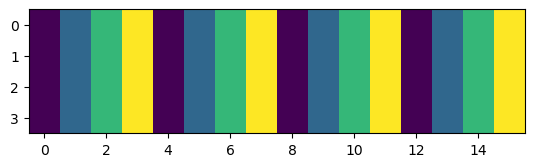

In [2]:
x_test = jnp.tile(jnp.array([0, 1, 2, 3]), 16)

plt.imshow(x_test.reshape(4, -1))

# makinf the core-wise permutation
p1 = jnp.eye(x_test.shape[0])
# plt.matshow(p1)
rand_perm = jax.random.permutation(rngs.params(), x_test.shape[0])
rand_perm_cores = jax.random.permutation(rngs.params(), 4)
p2 = jnp.eye(x_res.shape[0])
p2 = p2[rand_perm_cores]
print(rand_perm)
p1 = p1[rand_perm]
print(f"Corewise permutation")
plt.matshow(p1)
print(f"Slot-wise permutation")
plt.matshow(p2)

x_scr = jnp.einsum('ij,j->i', p1, x_test)
print(f"Scrambled inputs to slots")
plt.matshow(x_scr.reshape(4, -1))

x_res = x_scr.reshape(4, -1)
x_scr2 = jnp.einsum('ij,jk->ik', p2, x_res)
# x_scr2 = x_scr2.reshape(-1,)
print(f"Copy of inputs to slots, scrambled")
plt.matshow(x_scr2)

print(f"xpos - xneg")
plt.matshow((x_scr - x_scr2.flatten()).reshape(4, -1))

In [ ]:
def visualize_permutation_matrix(P):
    """
    Visualize a permutation matrix as a bipartite graph.
    
    Parameters:
    -----------
    P : numpy.ndarray
        A permutation matrix (n x n) with entries of 0s and 1s
    """
    n = P.shape[0]  # Size of the permutation matrix (assuming square)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 12))
    
    # Set positions for left and right columns of dots
    left_x = 0.2
    right_x = 0.8
    y_positions = jnp.linspace(0.05, 0.95, n)
    
    # Plot dots for left column (input slots)
    left_points = []
    for i in range(n):
        left_points.append((left_x, y_positions[i]))
        ax.plot(left_x, y_positions[i], 'o', color='blue', markersize=6)
        ax.text(left_x - 0.05, y_positions[i], f"{i+1}", ha='right', va='center')
    
    # Plot dots for right column (output slots)
    right_points = []
    for i in range(n):
        right_points.append((right_x, y_positions[i]))
        ax.plot(right_x, y_positions[i], 'o', color='green', markersize=6)
        ax.text(right_x + 0.05, y_positions[i], f"{i+1}", ha='left', va='center')
    
    # Draw lines based on the permutation matrix
    for i in range(n):
        j = jnp.where(P[i] == 1)[0][0]  # Find the position of 1 in row i
        ax.plot([left_x, right_x], [y_positions[i], y_positions[j]], 
                '-', color='gray', alpha=0.7, linewidth=0.8)
    
    # Set plot limits and remove axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    # Add title and labels
    plt.title('Permutation Matrix Visualization')
    plt.text(left_x, 0.01, 'Input Slots', ha='center')
    plt.text(right_x, 0.01, 'Output Slots', ha='center')
    
    plt.tight_layout()
    return fig

fig = visualize_permutation_matrix(p1)
plt.show()

## Thinking in terms of modules

In [ ]:
# a single core
class Core